# MNIST experiments

In [ ]:
# | hide
import math
import torch
import torchvision.transforms as T
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from fastai.vision.all import *

Hyper-parameters

In [ ]:
set_seed(0)
n_cores = num_cpus()


bs = 256 # batch size
h = 256

First load the MNIST dataset

In [ ]:
from torchvision.datasets import MNIST

mean, std = 0.130652368068695068, 0.307504087686538696

train_dataset = MNIST('../data', train=True, download=True,
                             transform=T.Compose([
                                 T.ToTensor(),
                                 T.Normalize((mean,), (std,))]))
test_dataset = MNIST('../data', train=False, download=True,
                            transform=T.Compose([
                                T.ToTensor(),
                                T.Normalize((mean,), (std,))]))

In [ ]:
dls = DataLoaders(TfmdDL(train_dataset, bs, True, n_cores),TfmdDL(test_dataset, bs, False, n_cores))

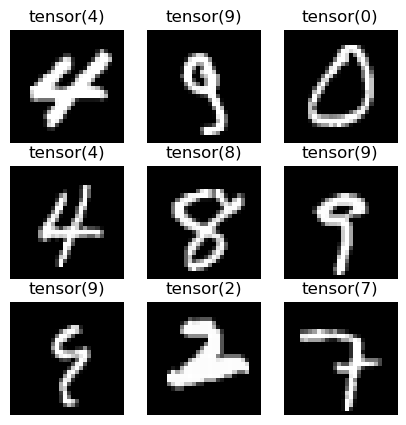

In [ ]:
show_image_batch(dls.one_batch(), cmap='gray', figsize=(5,5))

In [ ]:
dls.one_batch()[0].shape

torch.Size([256, 1, 28, 28])

# Baseline
Baseline model with single hidden layer with `h` hidden neurons

In [ ]:
model_ff = nn.Sequential(
    nn.Linear(28*28, h),
    nn.PReLU(),
    nn.Linear(h, 2), # learn 2d projection
    nn.PReLU(),
    nn.Linear(2, 10)
)

Add callback that flattens 28x28 images into vectors of size 784 

In [ ]:
@before_batch_cb
def flatten(self, xb, yb): 
    return (xb[0].view(-1,28*28),),yb

In [ ]:
cbs = [flatten, ShowGraphCallback()]
learn = Learner(dls, model_ff, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.563269,0.420080,0.908800,00:11
1,0.349416,0.333711,0.929400,00:12
2,0.256206,0.288936,0.934700,00:12
3,0.231394,0.282841,0.942000,00:11
4,0.197889,0.247934,0.946900,00:11
5,0.172981,0.269958,0.943600,00:11
6,0.158365,0.264189,0.949500,00:12
7,0.147270,0.293472,0.943300,00:11
8,0.129061,0.265021,0.949200,00:12
9,0.128965,0.283412,0.949900,00:11


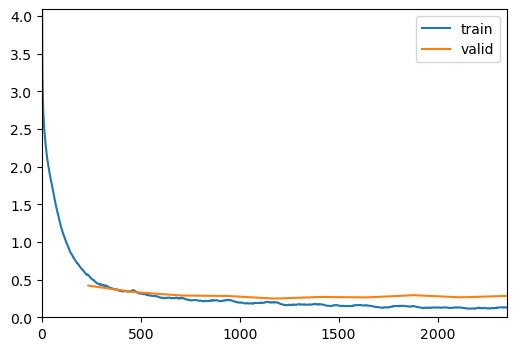

In [ ]:
learn.fit(10, lr=1e-2)

In [ ]:
# TODO get activations each epoch during training
class Activations2D(HookCallback):
    def __init__(self, module = None, **kwargs):
        super().__init__([module], **kwargs)
        
    def before_fit(self):
        super().before_fit()
        self.activations, self.targets = [], []
    
    def hook(self, m, i, o): return o
    
    def after_batch(self):
        '''Store activations and targets for batch'''
        self.activations.append(self.hooks.stored[0])
        self.targets.append(self.yb[0])
        super().after_batch()
        
    def after_fit(self):
        self.activations, self.targets = torch.cat(self.activations), torch.cat(self.targets)
        super().after_fit()
    
    def show_acts(self, figsize=(10,5), ax=None, alpha=0.6, s=5, cmap='tab10', **kwargs):
        if ax is None: _, ax = plt.subplots(figsize=figsize)
        sc = ax.scatter(self.activations[:,0], self.activations[:,1], alpha=alpha,
                   c=self.targets.tolist(), label=self.targets.tolist(), s=s, cmap=cmap, **kwargs)
        ax.set_title('2D activations')
        ax.legend(*sc.legend_elements())

In [ ]:
act = Activations2D(model_ff[-3])
learn.get_preds(dl = dls.valid, cbs=act);

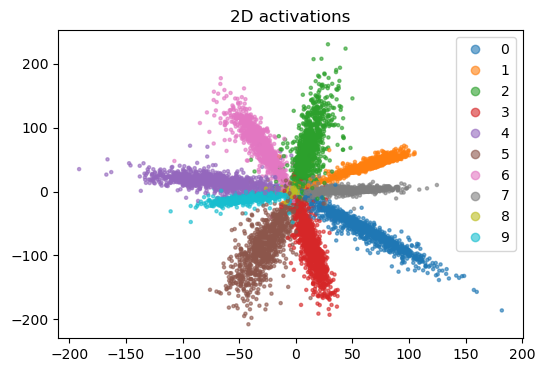

In [ ]:
act.show_acts(figsize=(6,4))

# Fast Feed-forward network

Feed-forward layer, Mixture-of-experts layer and Fast Feed-forward layer.

FFF forms a tree that splits space into regions

<img width="900" src="../images/ff_moe_fff.png" id="jupyter"/>

### First implementation from https://github.com/pbelcak/fastfeedforward/blob/main/fastfeedforward/fff.py

In [ ]:
import fff
ls = 8                   # leaf size
d = int(math.log2(h/ls)) # depth so that number of output neurons is h
model_fff = nn.Sequential(fff.FFF(28*28, ls, 2, d), nn.PReLU(), nn.Linear(2, 10))

Comparison for number of parameters

In [ ]:
def num_params(model): return sum(p.numel() for p in model.parameters())

In [ ]:
num_params(model_fff), num_params(model_ff)

(225903, 201506)

epoch,train_loss,valid_loss,accuracy,time
0,0.610725,0.648341,0.868200,00:15
1,0.507152,0.575689,0.871900,00:16
2,0.474279,0.539926,0.890700,00:23
3,0.422442,0.522280,0.898100,00:15
4,0.444350,0.530654,0.894700,00:15
5,0.400934,0.494338,0.903500,00:15
6,0.415445,0.508945,0.899800,00:20
7,0.403139,0.481702,0.899000,00:16
8,0.386169,0.504052,0.906300,00:15
9,0.369087,0.502665,0.892400,00:16


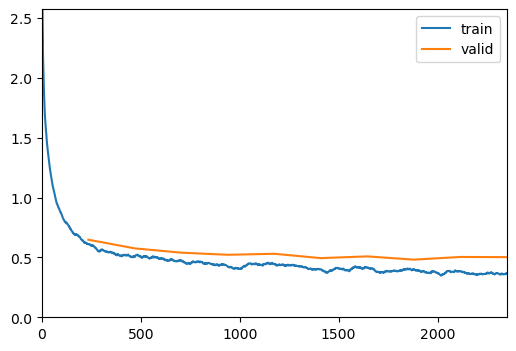

In [ ]:
cbs = [ShowGraphCallback(), flatten]
learn = Learner(dls, model_fff, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)
learn.fit(10, lr=2e-2)

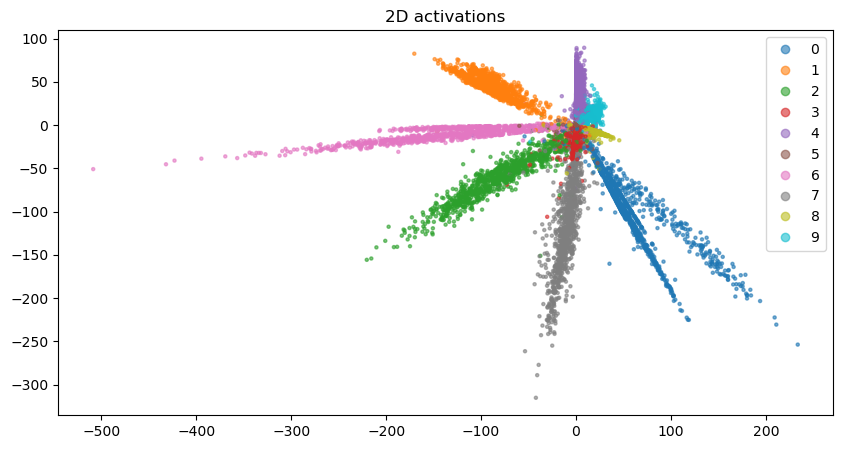

In [ ]:
act = Activations2D(model_fff[-3])
learn.get_preds(dl = dls.valid, cbs=act);
act.show_acts(figsize=(10,5), cmap='tab10')

### Second implentation is from UltraFastBERT repository. 

This tree does not have sigmoids and leaves

In [ ]:
# from https://github.com/pbelcak/UltraFastBERT/blob/main/training/cramming/architectures/fff.py

class FFF(nn.Module):
	def __init__(self, input_width, output_width, depth, parallel_size, activation=nn.PReLU):
		super().__init__()

		self.input_width = input_width
		self.output_width = output_width
		self.depth = depth
		self.parallel_size = parallel_size
		self.n_nodes = 2 ** (self.depth + 1) - 1

		self.linear_in = nn.Linear(input_width, parallel_size * self.n_nodes, bias=True)
		self.linear_out = nn.Linear(parallel_size * self.n_nodes, output_width, bias=False)

		init_k = math.sqrt(1.0 / self.input_width)
		self.linear_in.weight.data = torch.empty((self.parallel_size * self.n_nodes, self.input_width)).uniform_(-init_k, +init_k)
		self.linear_in.bias.data = torch.empty((self.parallel_size * self.n_nodes)).uniform_(-init_k, +init_k)
		init_k2 = math.sqrt(1.0 / ((self.depth+1) * self.parallel_size))
		self.linear_out.weight.data = torch.empty((self.output_width, self.parallel_size * self.n_nodes)).uniform_(-init_k2, +init_k2)

		self.activation = activation()

	def forward(self, oldx: torch.Tensor) -> torch.Tensor:
		# x has shape (..., input_width)
		x = oldx.reshape(-1, self.input_width)
		# x has shape (batch_size, input_width)
		batch_size = x.shape[0]

		logits = self.linear_in(x) # (batch_size, parallel_size * n_nodes)
		# calculated every decision for a whole tree by logits from each layer
		logit_decisions = (logits > 0).long() # (batch_size, parallel_size * n_nodes)
		activations = self.activation(logits) # (batch_size, parallel_size * n_nodes)

		# recursively descending by depth, enforce conditionality
		activations = activations.view(batch_size, self.parallel_size, self.n_nodes) # (batch_size, parallel_size, n_nodes)
		decisions = logit_decisions.view(batch_size, self.parallel_size, self.n_nodes) # (batch_size, parallel_size, n_nodes)

		with torch.no_grad():
			current_nodes = torch.zeros((batch_size, self.parallel_size), dtype=torch.long, device=x.device)
			decision_map = torch.zeros_like(decisions, dtype=torch.float) # (batch_size, parallel_size, n_nodes)
			decision_map.scatter_(dim=2, index=current_nodes.unsqueeze(-1), value=1.0)

			for d in range(self.depth):
				current_platform = 2 ** d - 1
				next_platform = 2 ** (d + 1) - 1
				moves = torch.gather(decisions, 2, current_nodes.unsqueeze(2)).squeeze(2)
				# 0 go left branch, 1 go right branch
				next_nodes = (current_nodes - current_platform) * 2 + moves + next_platform
				# next_nodes = current_nodes*2 + moves + 1 			# the same as line above
				decision_map.scatter_(2, next_nodes.unsqueeze(-1), 1.0)
				current_nodes = next_nodes
		# decision map has 1 on indices of nodes on path which sample took, 0 otherwise
		activations = activations * decision_map # (batch_size, parallel_size, n_nodes)
		new_logits = self.linear_out(activations.flatten(1, 2)) # (batch_size, output_width)

		return new_logits

In [ ]:
n_trees = 8                     # number of trees
d = int(math.log2(h/n_trees)-1) # depth of the tree
model_fff2 = nn.Sequential(FFF(28*28, 2, d, n_trees), nn.PReLU(), nn.Linear(2, 10))

In [ ]:
num_params(model_fff2), num_params(model_ff)

(195208, 201506)

epoch,train_loss,valid_loss,accuracy,time
0,0.557896,0.487332,0.883400,00:12
1,0.431323,0.413167,0.898300,00:11
2,0.386342,0.387117,0.910500,00:12
3,0.343443,0.365436,0.919500,00:12
4,0.307473,0.379700,0.917600,00:13
5,0.288371,0.365554,0.925400,00:13
6,0.276644,0.356611,0.925300,00:12
7,0.259358,0.315323,0.932500,00:12
8,0.235891,0.338721,0.932500,00:12
9,0.241468,0.393270,0.922100,00:14


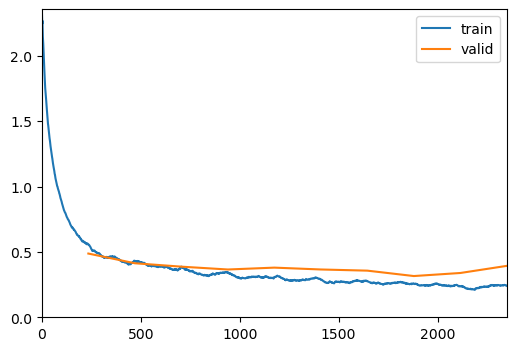

In [ ]:
cbs = [ShowGraphCallback(), flatten]
learn = Learner(dls, model_fff2, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)
learn.fit(10, lr=2e-2)

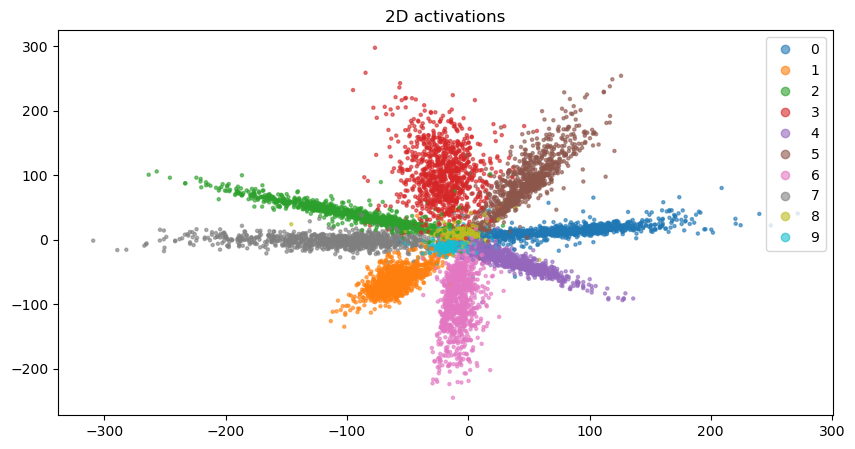

In [ ]:
act = Activations2D(model_fff2[-3])
learn.get_preds(dl = dls.valid, cbs=act)
act.show_acts(figsize=(10,5), cmap='tab10')

# Convolutional network

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=nn.PReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [ ]:
model_cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    nn.Flatten(),
    nn.Linear(64, 2),      # 2d projection
    nn.PReLU(),
    nn.Linear(2, 10)
)

epoch,train_loss,valid_loss,accuracy,time
0,0.451598,0.365126,0.918600,00:14
1,0.273179,0.259953,0.942700,00:12
2,0.204982,0.220409,0.951900,00:13
3,0.196523,0.202177,0.955900,00:13
4,0.180651,0.201886,0.958100,00:13
5,0.167538,0.189373,0.961200,00:15
6,0.149741,0.168048,0.960800,00:14
7,0.150670,0.163318,0.963100,00:13
8,0.141889,0.178597,0.965200,00:12
9,0.133301,0.166014,0.966900,00:14


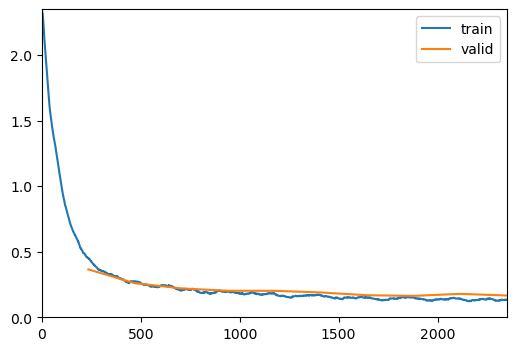

In [ ]:
cbs = [ShowGraphCallback()]
learn = Learner(dls, model_cnn, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)
learn.fit(10, lr=1e-2)

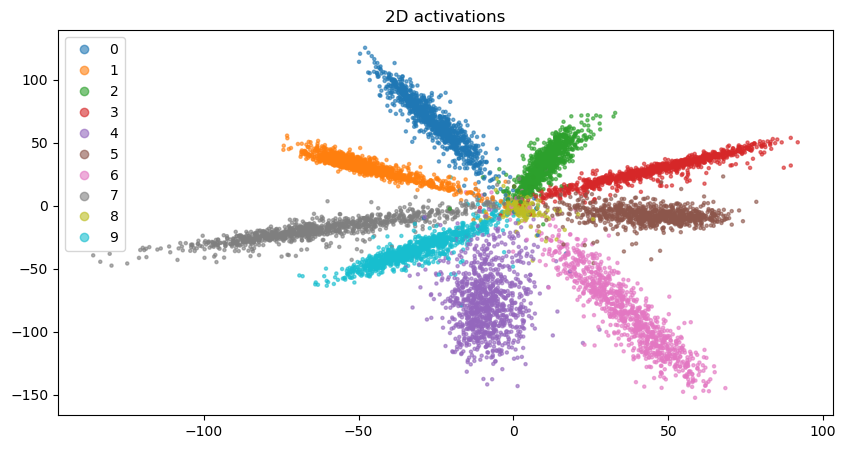

In [ ]:
act = Activations2D(model_cnn[-3])
learn.get_preds(dl = dls.valid, cbs=act);
act.show_acts(figsize=(10,5))